# Constraining Modified Newtonian Dynamics (MOND)
In this part of the assignment, we will attempt to use our orbit solver to place a constraint on Modified Newtonian Dynamics (MOND), which is sometimes used as an alternative to dark matter.

In a MOND scheme, Newton's second law is modified to the following:
$$
    F = m a \times \mu \left( \frac{a}{a_0} \right) \tag{1}
$$
where $a_0$ is a constant with units of acceleration, and $\mu(x)$ is called the "interpolating function". Agreement with observation requires that $\mu(x)$ behaves as follows:
$$
    \mu(x) \to 1 \; \textrm{for } x \gg 1, \\
    \mu(x) \to x \; \textrm{for } x \ll 1.
$$
Two common choices for $\mu(x)$ are the "simple interpolating function":
$$
    \mu(x) = \frac{1}{1 + x^{-1}} \tag{2}
$$
and the "standard interpolating function":
$$
    \mu(x) = \sqrt{\frac{1}{1 + x^{-2}}}. \tag{3}
$$

Per the definition of $\mu(x)$, within the solar system we would expect the MOND acceleration to differ from the ordinary Newtonian acceleration most significantly for the outermost planets. Therefore, we will study the orbit of Neptune with and without MOND, comparing to data from JPL Horizons.

### Assignment
1. Modify your `getAcc` function to accept a new parameter, `a0`, which is the MOND constant. Modify the output of the function to compute the MOND acceleration, using either the simple or standard interpolating function. (Hint: this requires inverting the relation $(1)$ to find $a$.)
2. Using the `getVectors` function provided below, obtain the orbit of Neptune from Horizons. Plot the $x$, $y$, and $z$ position versus time to compare the Horizons data to the simulated Newtonian orbit that you obtained in the first part of this assignment. Include errorbars on the Horizons data using the provided uncertainties in the $x$, $y$, and $z$ positions. Also plot the residuals (you may need to interpolate the Horizons data in order to do this; see the `make_interp_spline` function from SciPy for this step). How well does the Newtonian simulation match Horizons? If it differs, why? 
3. Repeat the N-body simulation with MOND. Plot position versus time and residuals for several values of `a0`. Try to obtain a rough upper bound on `a0`, above which the MOND simulation is incompatible with the known orbit of Neptune from Horizons (this can be fairly qualitative; argue using both the provided uncertainties, and by comparing the MOND simulation to the Newtonian simulation).

Note: The uncertainties on the position of Neptune provided below are greatly exaggerated for the sake of simplicity. If we were using more realistic uncertainties, we would also need to use a much more realistic Newtonian simulation, including the effects of the other bodies in the solar system which we ignored.

Fetching initial conditions from JPL Horizons...
Initial conditions fetched successfully.

Fetching observational data from JPL Horizons for Neptune...
Observational data fetched successfully.

Running simulation with a0 = 0...
Simulation with a0 = 0 completed.

Running simulation with a0 = 1e-10...
Simulation with a0 = 1e-10 completed.

Running simulation with a0 = 1e-09...
Simulation with a0 = 1e-09 completed.

Running simulation with a0 = 1e-08...
Simulation with a0 = 1e-08 completed.

Running simulation with a0 = 0.0001...
Simulation with a0 = 0.0001 completed.

Running simulation with a0 = 0.01...
Simulation with a0 = 0.01 completed.


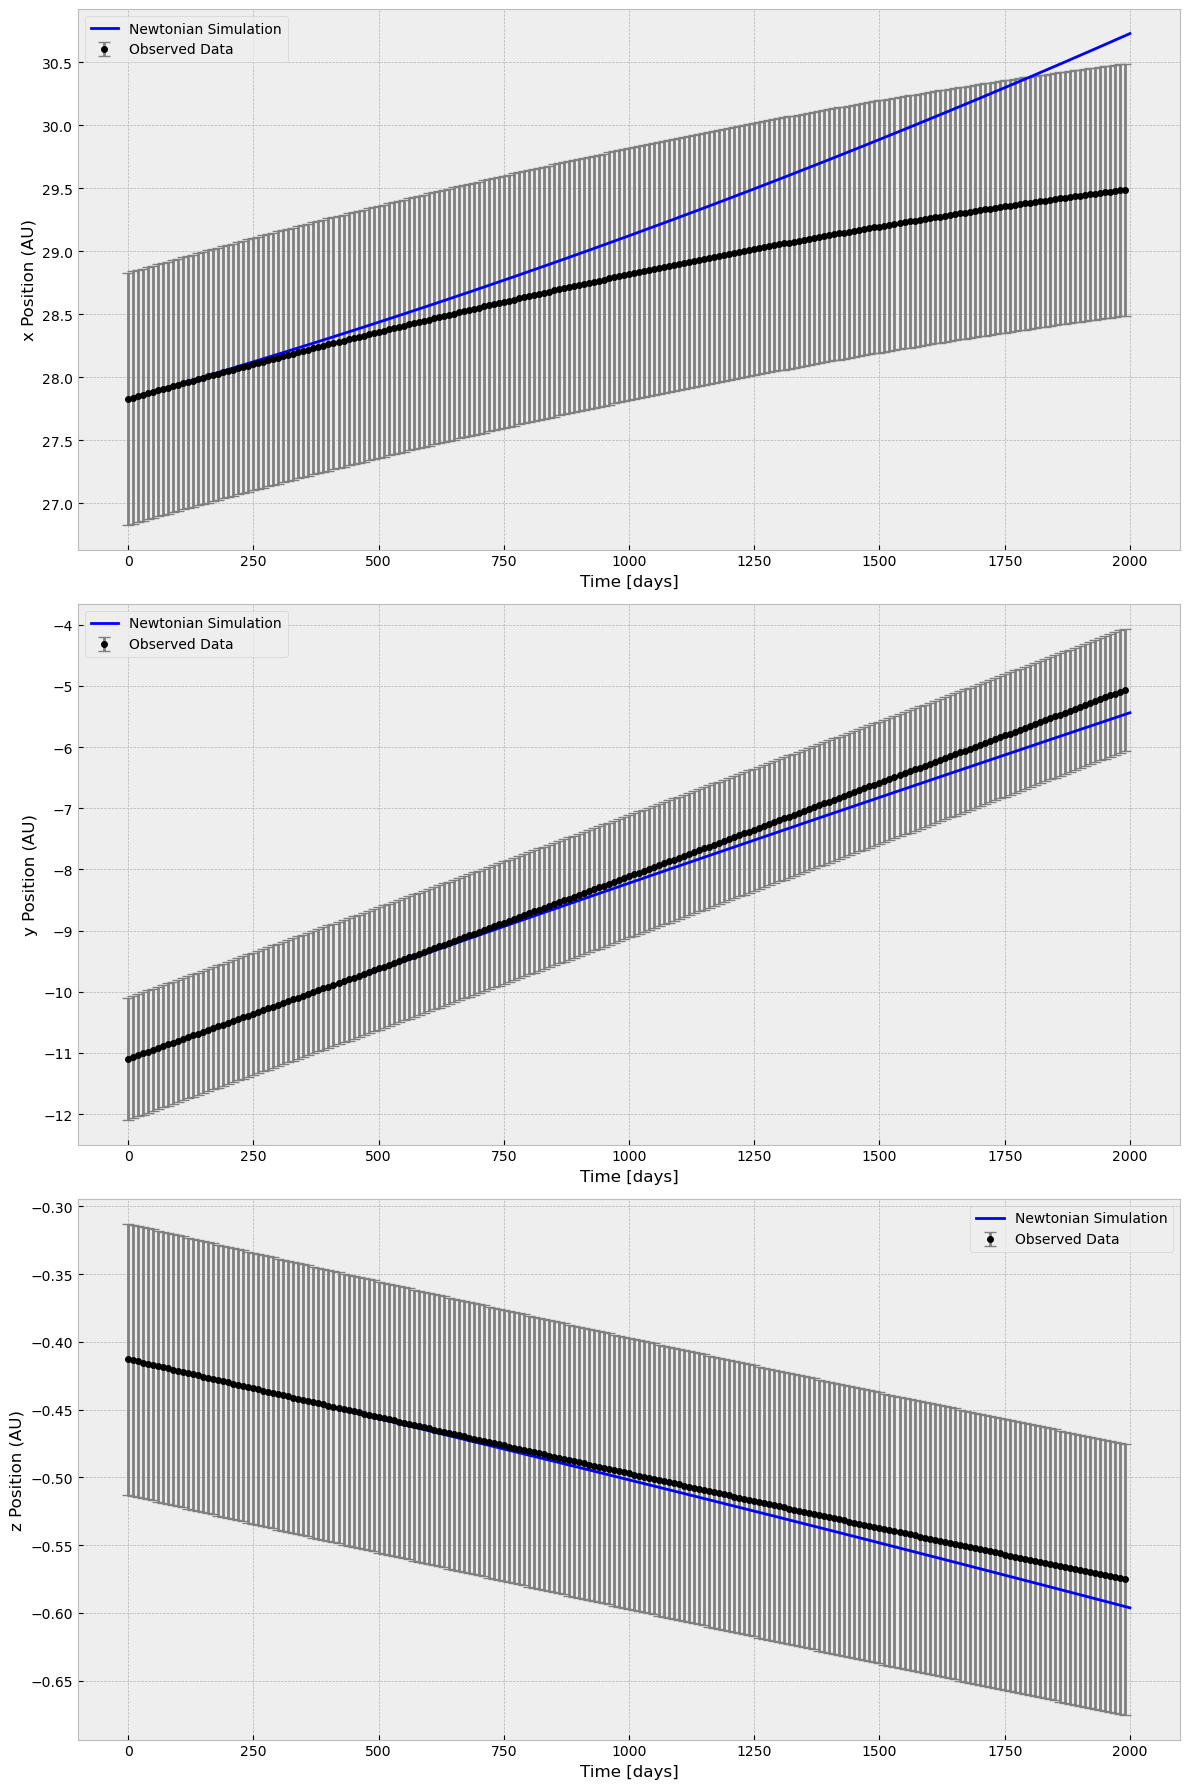

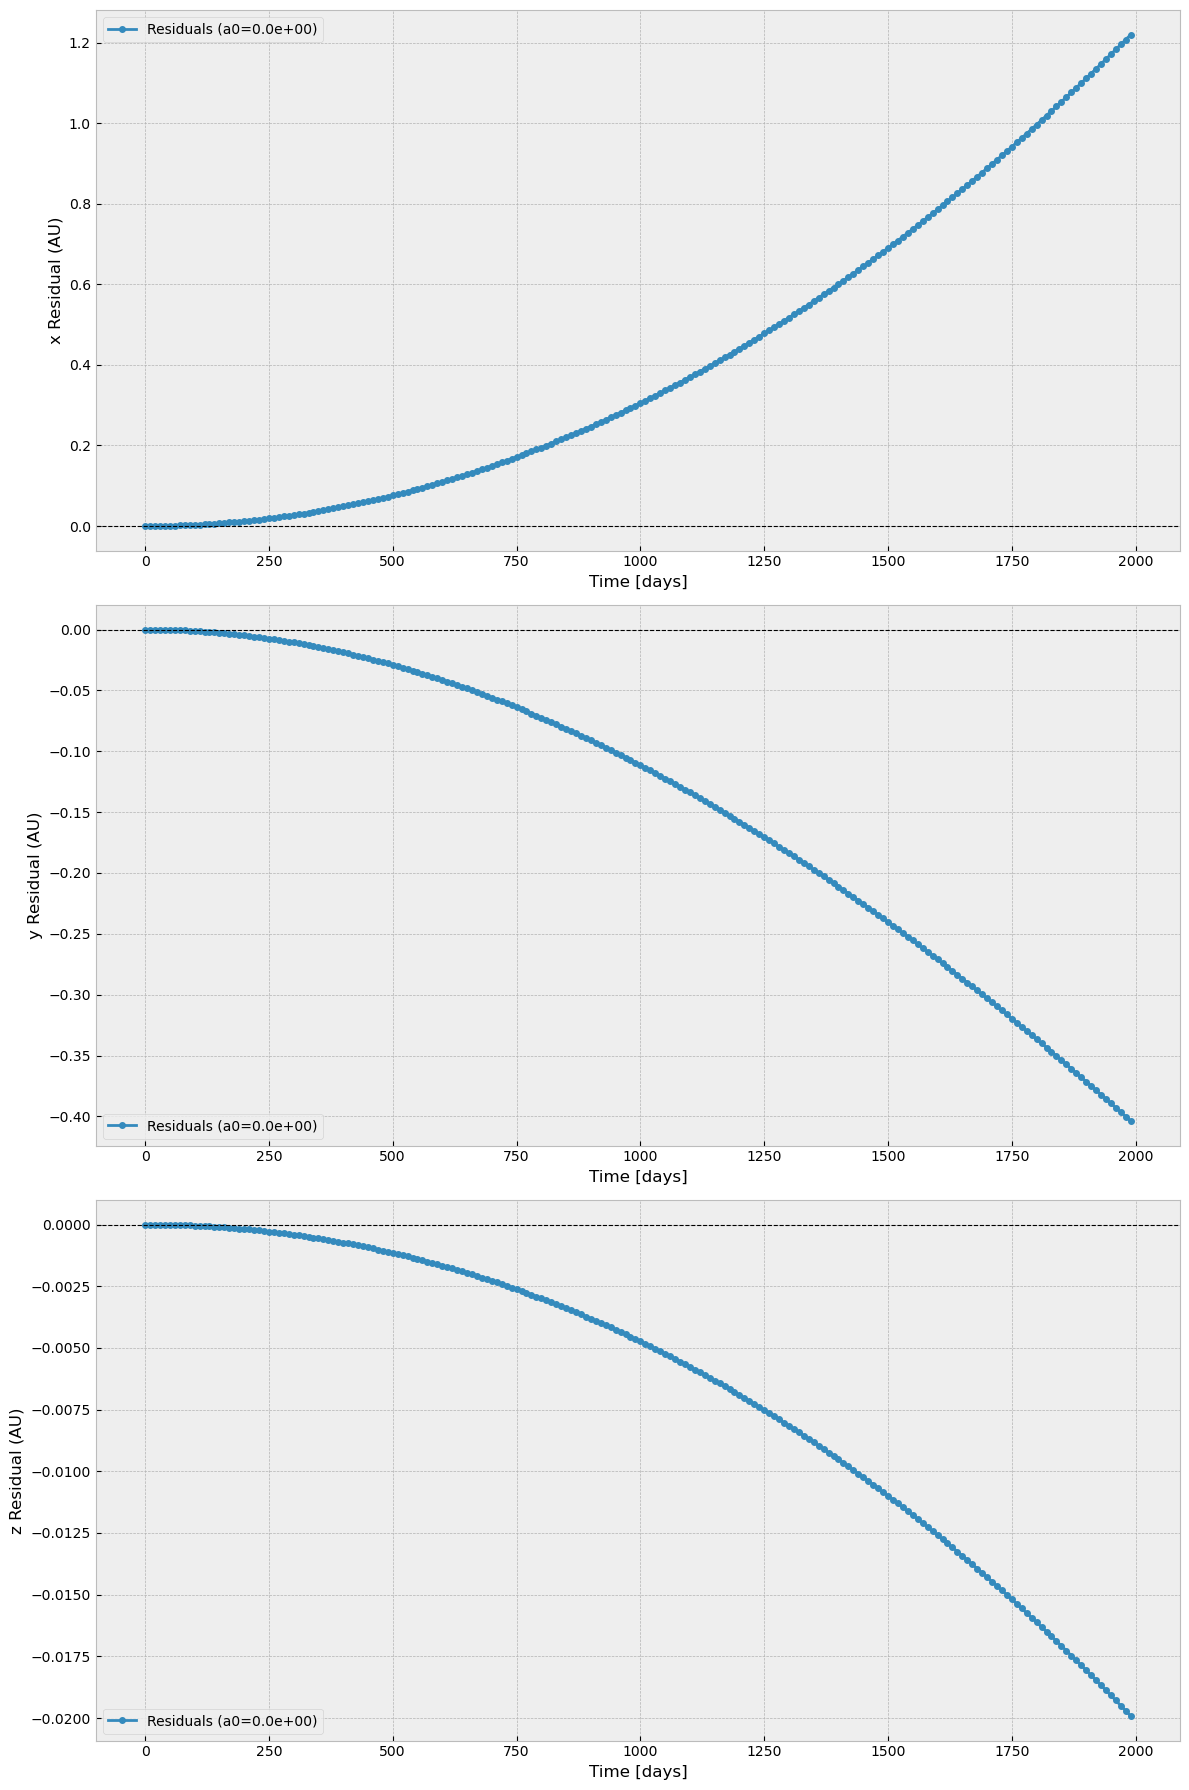

a0 = 0.0e+00
  Mean Residuals: [ 0.4059126  -0.14127618 -0.0064642 ]
  Std Dev Residuals: [0.36540704 0.12258319 0.00592993]


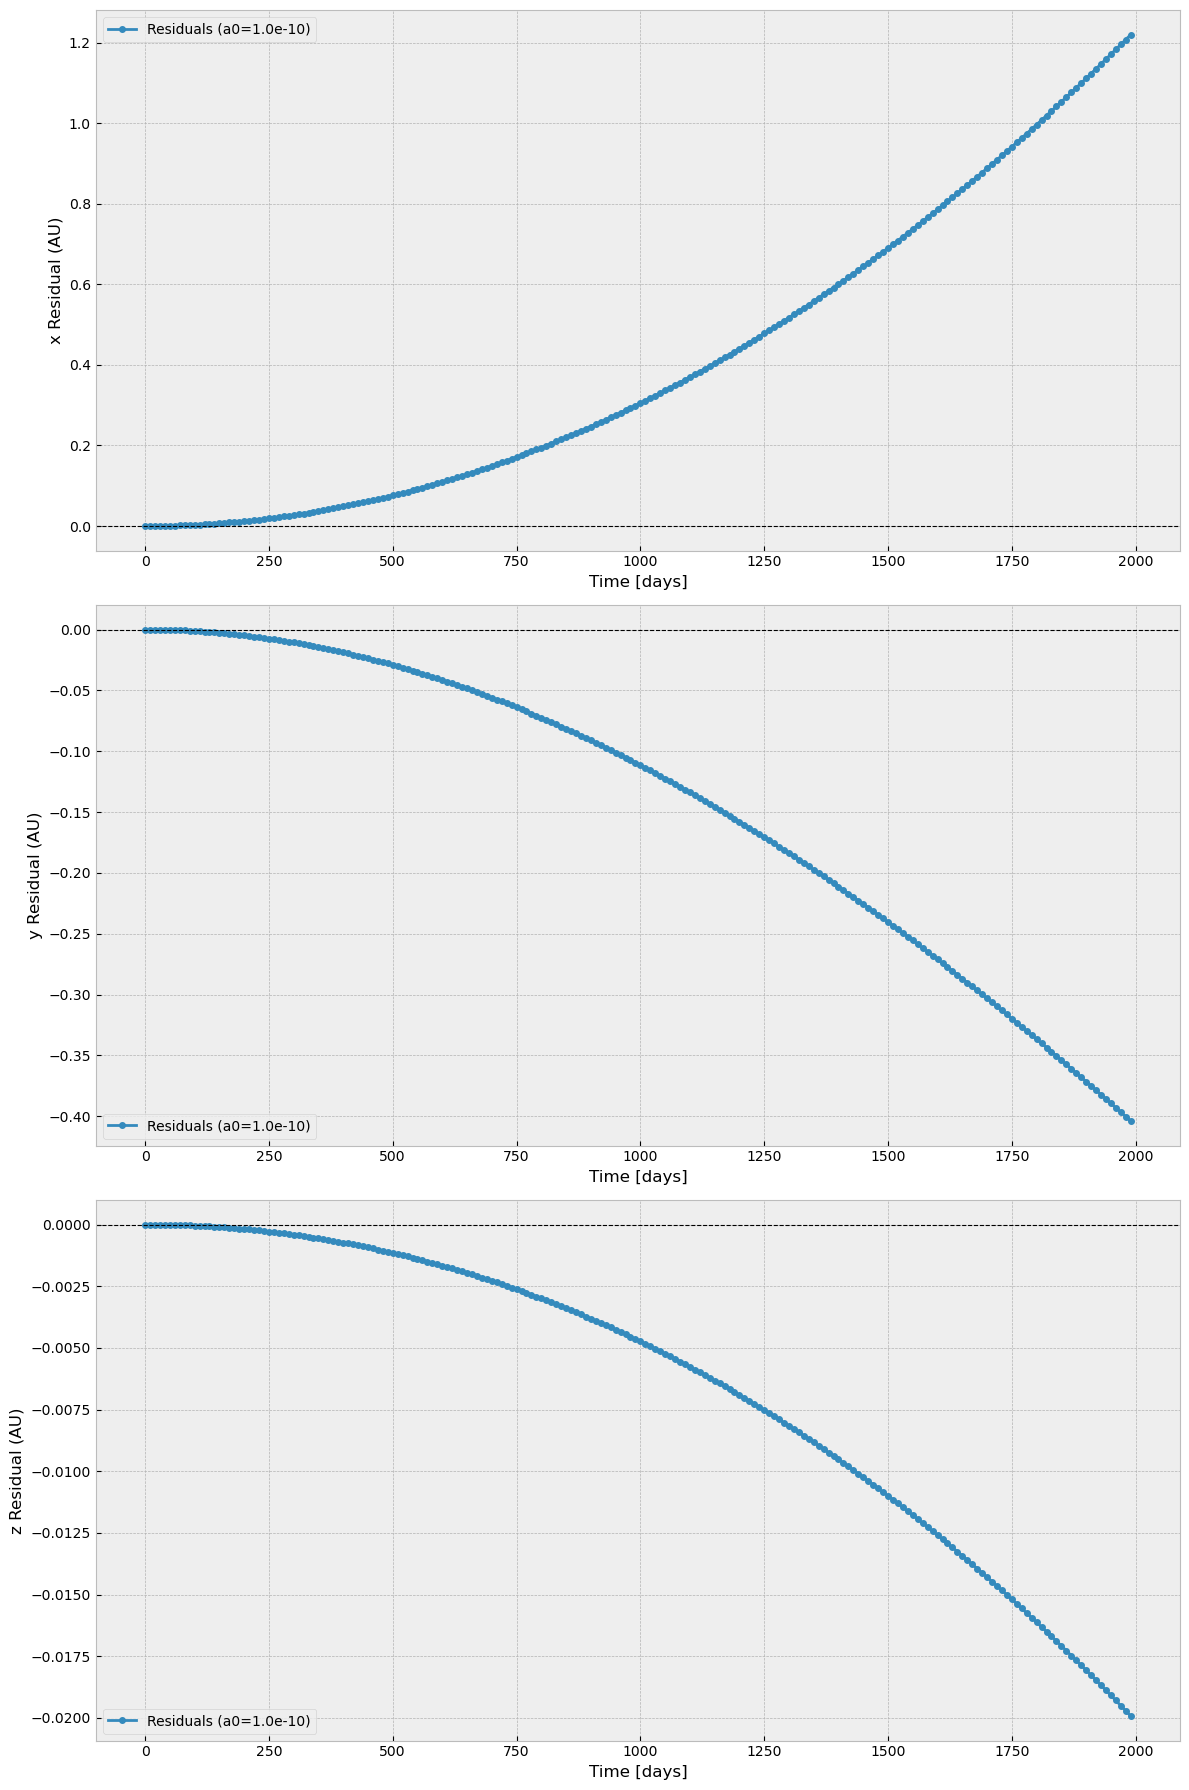

a0 = 1.0e-10
  Mean Residuals: [ 0.40597482 -0.14129734 -0.0064652 ]
  Std Dev Residuals: [0.36546294 0.12260143 0.00593085]


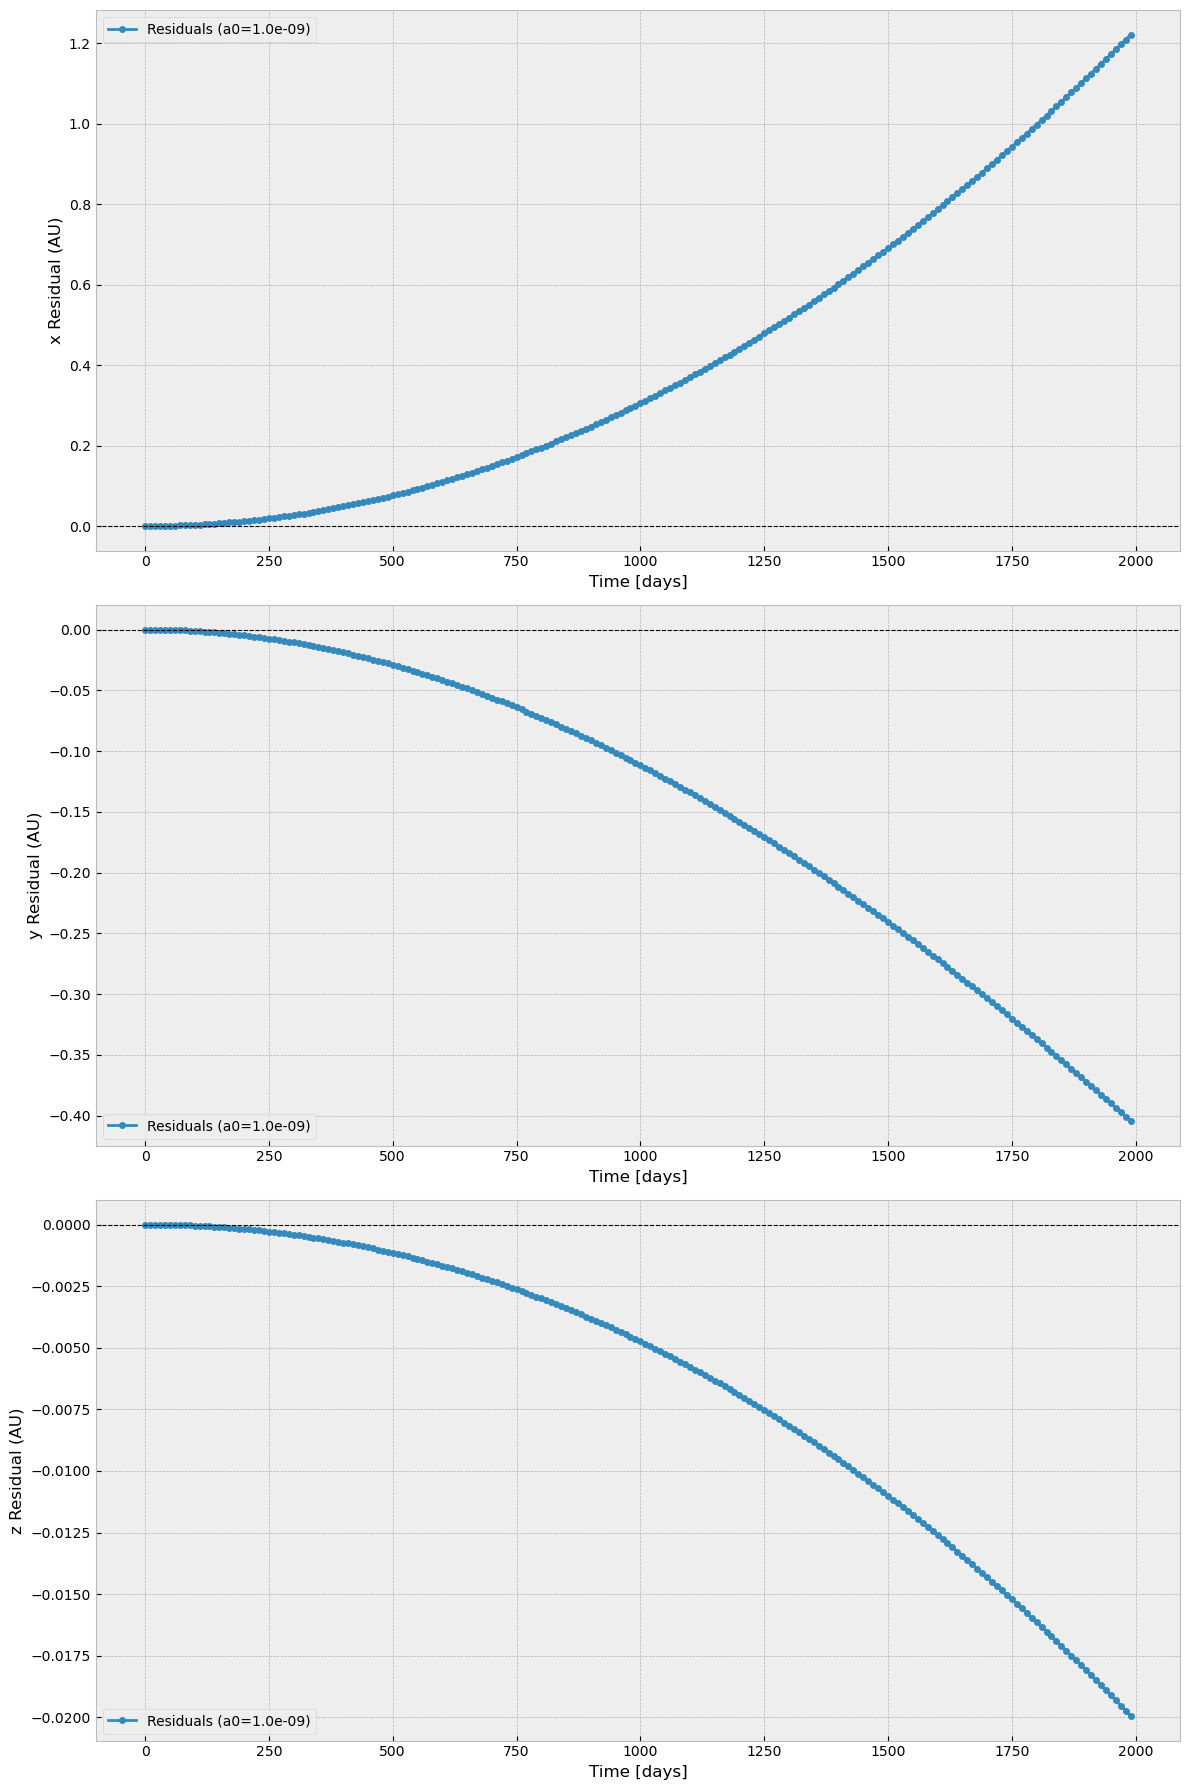

a0 = 1.0e-09
  Mean Residuals: [ 0.40653363 -0.14148738 -0.00647416]
  Std Dev Residuals: [0.36596522 0.12276525 0.00593905]


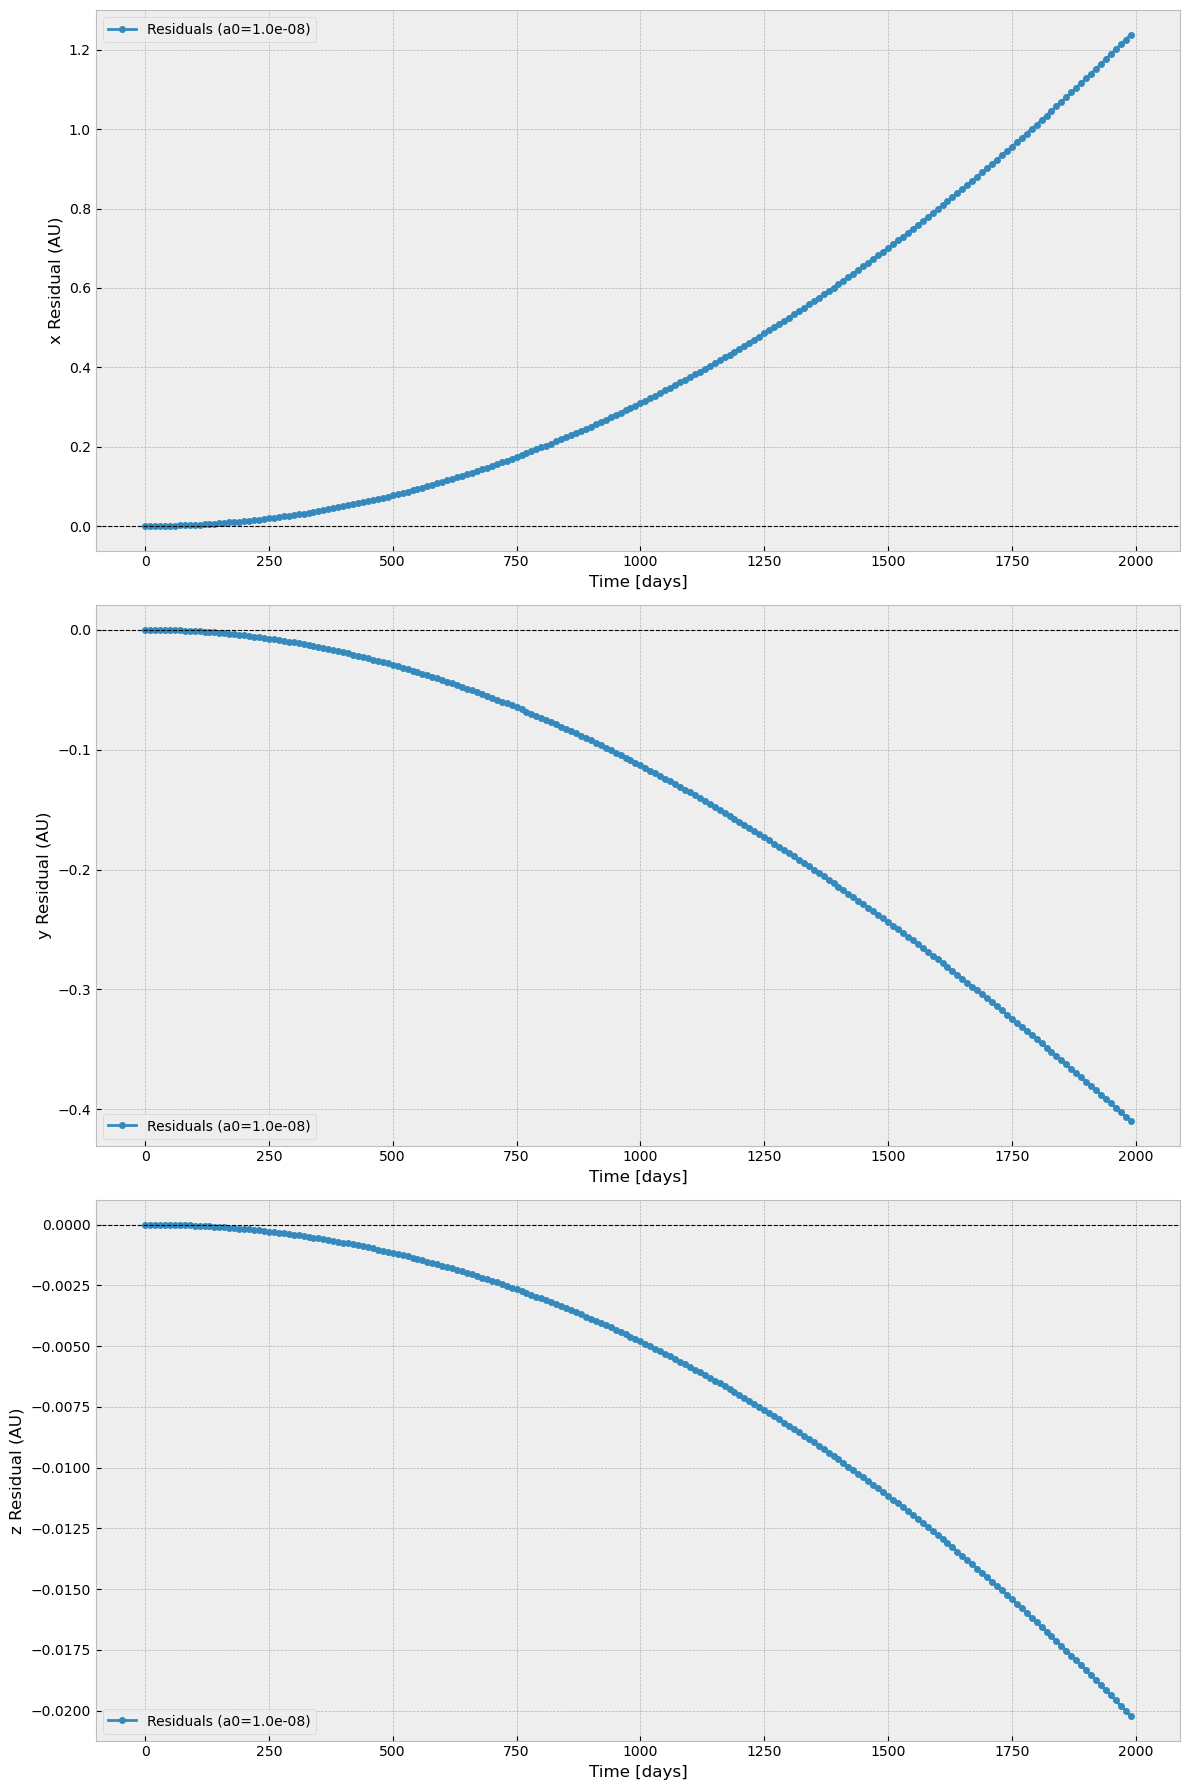

a0 = 1.0e-08
  Mean Residuals: [ 0.41196419 -0.14333418 -0.00656128]
  Std Dev Residuals: [0.37084653 0.12435722 0.0060188 ]


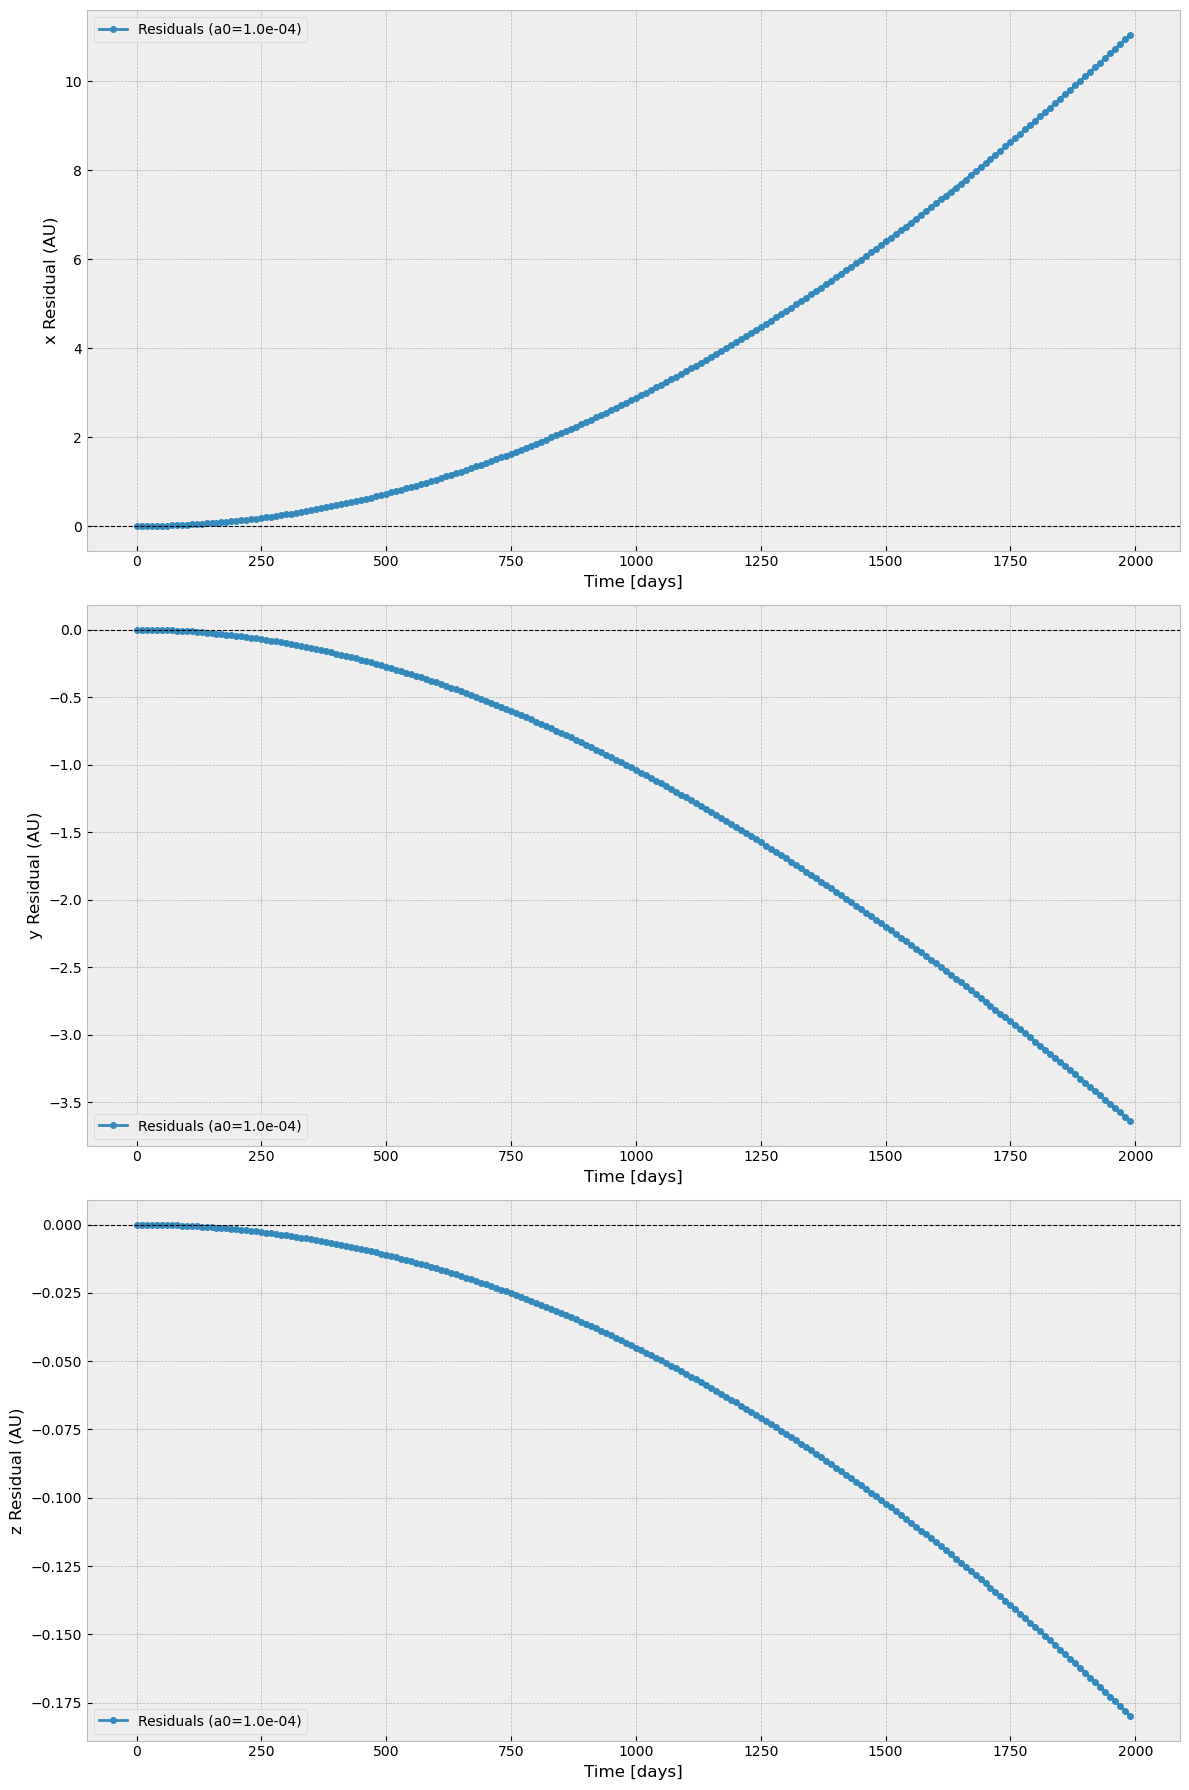

a0 = 1.0e-04
  Mean Residuals: [ 3.75702906 -1.29504285 -0.05993404]
  Std Dev Residuals: [3.33311028 1.10855922 0.05403298]


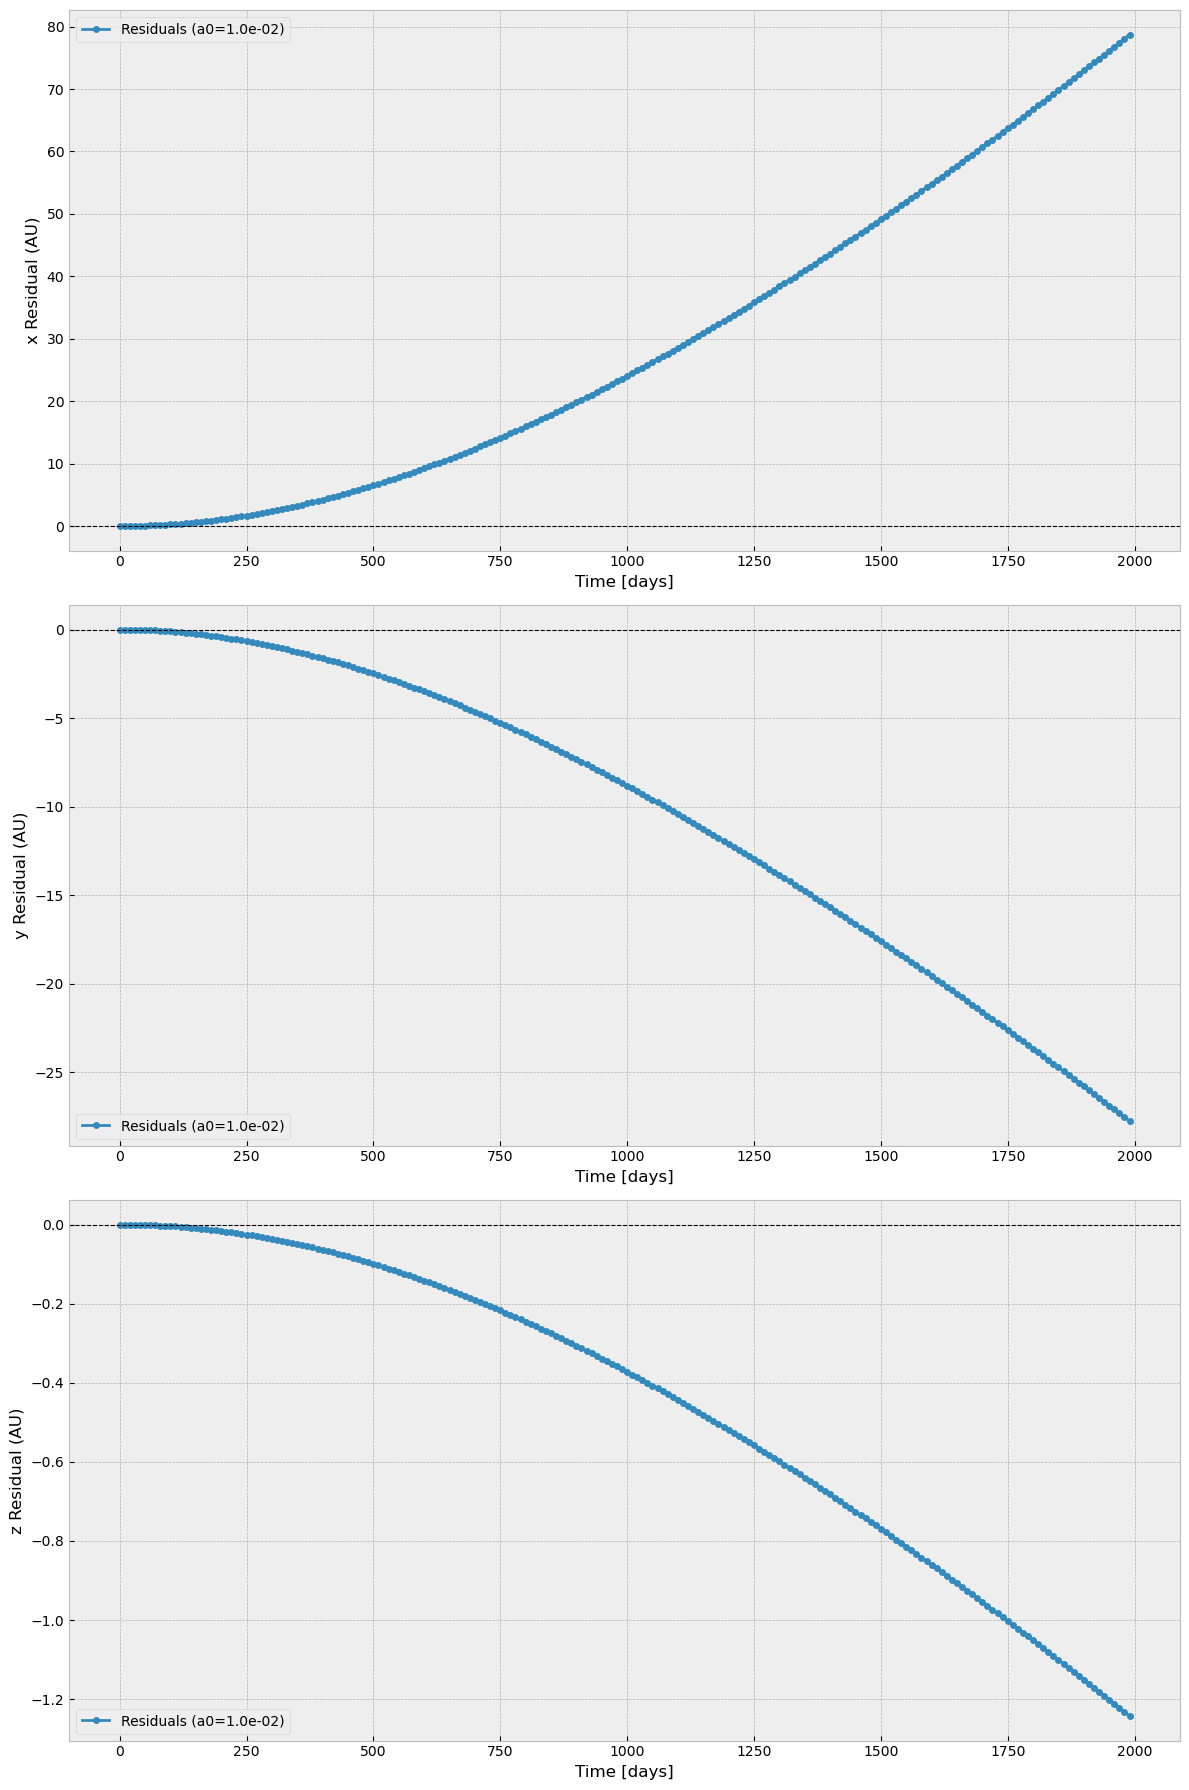

a0 = 1.0e-02
  Mean Residuals: [ 28.97103878 -10.42494138  -0.45298394]
  Std Dev Residuals: [24.17049607  8.539038    0.38123136]


In [56]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
from astropy.time import Time, TimeDelta
from astroquery.jplhorizons import Horizons
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from scipy.interpolate import make_interp_spline

plt.style.use('bmh') 

# Define the getAcc function with MOND corrections
def getAcc(pos, mass, G, softening, a0, interpolating_function='simple'):
    N = pos.shape[0]
    dx = pos[:, np.newaxis, :] - pos[np.newaxis, :, :]
    r2 = np.sum(dx**2, axis=2) + softening**2
    inv_r3 = np.where(r2 > 0, r2**(-1.5), 0)[:, :, np.newaxis]
    mass_j = mass[np.newaxis, :, np.newaxis]
    a_N = G * np.sum(dx * inv_r3 * mass_j, axis=1)

    if a0 == 0:
        return a_N  

    a_N_mag = np.linalg.norm(a_N, axis=1)
    a_corrected = np.zeros_like(a_N)
    for i in range(N):
        def mond_func(a_mag):
            x = a_mag / a0
            if interpolating_function == 'simple':
                mu = x / (1 + x)
            elif interpolating_function == 'standard':
                mu = x / np.sqrt(1 + x**2)
            else:
                raise ValueError("Unknown interpolating function")
            return a_mag * mu - a_N_mag[i]
        a_mag_solution = fsolve(mond_func, a_N_mag[i])[0]
        if a_N_mag[i] > 0:
            a_corrected[i] = (a_mag_solution / a_N_mag[i]) * a_N[i]
        else:
            a_corrected[i] = a_N[i]
    return a_corrected


#  get position and velocity vectors from Horizons
def getVectors(id=3, start="2023-11-05", stop="2024-11-05", step='2d'):
    epochs = {'start': start, 'stop': stop, 'step': step}
    obj = Horizons(id=id, location="@sun", epochs=epochs).vectors()
    t = np.array(obj['datetime_jd']) - obj['datetime_jd'][0]
    pos = np.array([obj[ix] for ix in ['x', 'y', 'z']]).T
    vel = np.array([obj[ix] for ix in ['vx', 'vy', 'vz']]).T
    return t, pos, vel


# Simulation Parameters
t_sim_start = 0
tEnd = 2000  
dt = 1
softening = 0.001
G_SI = const.G.value  
G = G_SI * (86400.0**2) / (1.495978707e11)**3 
start_date = '2015-09-14'

start_time = Time(start_date)
stop_time = start_time + TimeDelta(tEnd * u.day)
stop_date = stop_time.iso.split()[0] 

print("Fetching initial conditions from JPL Horizons...")
t_sun, pos_sun, vel_sun = getVectors(id='Sun', start=start_date, stop=stop_date, step='1d')
t_neptune, pos_neptune, vel_neptune = getVectors(id='Neptune Barycenter', start=start_date, stop=stop_date, step='1d')
print("Initial conditions fetched successfully.")

M_sun = const.M_sun.value 
mass_neptune = 1.024e26   
masses = np.array([M_sun, mass_neptune])  

pos = np.vstack((pos_sun[0], pos_neptune[0])) 
vel = np.vstack((vel_sun[0], vel_neptune[0]))  
y0 = np.hstack((pos.flatten(), vel.flatten())) 

# Define the derivative function for ODE solver
def derivs(t, y, mass, G, softening, a0, interpolating_function):
    N = int(len(y) / 6)
    pos = y[:3 * N].reshape((N, 3))
    vel = y[3 * N:].reshape((N, 3))
    acc = getAcc(pos, mass, G, softening, a0, interpolating_function)
    dydt = np.zeros_like(y)
    dydt[:3 * N] = vel.flatten()
    dydt[3 * N:] = acc.flatten()
    return dydt

t_span = (0, tEnd)
t_eval = np.linspace(0, tEnd, int(tEnd / dt))


# Fetch Horizons data for Neptune
print("\nFetching observational data from JPL Horizons for Neptune...")
t_horizons, pos_horizons, vel_horizons = getVectors(
    id='Neptune Barycenter', start=start_date, stop=stop_date, step='10d'
)
print("Observational data fetched successfully.")
sigma_x, sigma_y, sigma_z = (1, 1, 0.1)  

# Run simulations with different a0 values
a0_values = [0, 1e-10, 1e-9, 1e-8,1e-4,1e-2]  
results = {}
for a0 in a0_values:
    print(f"\nRunning simulation with a0 = {a0}...")
    sol = solve_ivp(
        derivs, t_span, y0,
        args=(masses, G, softening, a0, 'simple'),
        t_eval=t_eval, rtol=1e-8
    )
    pos_sim = sol.y[:6].T.reshape(-1, 2, 3)
    results[a0] = pos_sim
    print(f"Simulation with a0 = {a0} completed.")
# Plot positions vs time with error bars (grey)
fig, axs = plt.subplots(3, 1, figsize=(12, 18))
components = ['x', 'y', 'z']
for i in range(3):
    axs[i].errorbar(t_horizons, pos_horizons[:, i], yerr=sigma_x if i < 2 else sigma_z,
                    fmt='o', label='Observed Data', markersize=4, color='black', ecolor='grey', capsize=4)
    axs[i].plot(t_eval, results[0][:, 1, i], '-', label='Newtonian Simulation', color='blue')
    axs[i].set_xlabel('Time [days]')
    axs[i].set_ylabel(f'{components[i]} Position (AU)')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# Residuals and Plots
for a0, pos_sim in results.items():
    interp_x = make_interp_spline(t_eval, pos_sim[:, 1, 0])
    interp_y = make_interp_spline(t_eval, pos_sim[:, 1, 1])
    interp_z = make_interp_spline(t_eval, pos_sim[:, 1, 2])
    pos_sim_interp = np.vstack((interp_x(t_horizons), interp_y(t_horizons), interp_z(t_horizons))).T

    residuals = pos_sim_interp - pos_horizons
    

    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    components = ['x', 'y', 'z']
    for i in range(3):
        axs[i].plot(t_horizons, residuals[:, i], 'o-', label=f'Residuals (a0={a0:.1e})', markersize=4)
        axs[i].axhline(0, color='k', linestyle='--', linewidth=0.8)
        axs[i].set_xlabel('Time [days]')
        axs[i].set_ylabel(f'{components[i]} Residual (AU)')
        axs[i].legend()
        axs[i].grid(True)

    plt.tight_layout()
    plt.show()

    
    mean_residual = np.mean(residuals, axis=0)
    std_residual = np.std(residuals, axis=0)
    print(f"a0 = {a0:.1e}")
    print(f"  Mean Residuals: {mean_residual}")
    print(f"  Std Dev Residuals: {std_residual}")

# -------------------------



The Newtonian simulation (blue line) shows a small systematic deviation from the JPL Horizons observational data (black points with grey error bars).
While the trend in all three components is broadly correct, the Newtonian simulation diverges a little bit from the observed data as time progresses.
The reason for that is that The simulation only considers the Sun and Neptune, ignoring perturbations from other planets (e.g., Jupiter, Saturn, Uranus) that significantly affect Neptune's orbit. 
Clearly, for a0 less than  1e-7 the residuals are reasonable but we cam see  for 1e-4 and above how the divergence is huge and residuals have higher orders of magnitudes.